In [95]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master('local[*]')
    .appName('PySparkShell')
    .getOrCreate()
)

spark.conf.set('spark.sql.session.timeZone', 'UTC')

In [2]:
import sys
import os

sys.path.append('/dbfs/cdr/library')

from pandas import set_option
set_option('display.max.columns', None)

# TODO: remove for Databricks
from dbutils import DBUtils, FileInfo
dbutils = DBUtils()

In [57]:
from typing import Dict, List, Optional

from sparkFunctions import create_tmp_parquet

# adds file system prefix /dbfs for local and dbfs: for databricks
def resolve(path: str) -> Optional[str]:
    try:
        prefix = dbutils.fs.ls('/')[0].path[:5]
        return prefix + path
    except Exception as error:
        print(error)

In [4]:
FOLDER = '/automation'

ZOOM_FOLDER = os.path.join(FOLDER, 'ZoomData')
BASE_FOLDER = os.path.join(FOLDER, 'OnBase')

In [209]:
path = os.path.join(ZOOM_FOLDER, 'formattedAccountCallLogs.parquet')
calls = spark.read.parquet(resolve(path))

calls.limit(5).toPandas()

,caller_name,caller_number,callee_name,callee_number,direction,duration,date_time,result,call_id,extension_number,id,name,type,call_type,caller_number_type,callee_number_type,path,has_recording,has_voicemail,date_time_est
0,Ashton Sower,409,Halfpenny Techn,+16102779100,outbound,75,2021-08-30T21:05:22Z,Call connected,7002332237789502144,409,PBO-YsLMTf2ncnsYKSuGvQ,Ashton Sower,user,pstn,1,2,pstn,False,False,2021-08-30 17:05:22.000
1,Annie Lewis,275,None,+18888958106,outbound,32,2021-08-30T21:05:35Z,Call connected,7002332293623987563,275,ukEdcYAiTSyjVGTPmdH5GQ,Annie Lewis,user,pstn,1,2,pstn,False,False,2021-08-30 17:05:35.000
2,Annie Lewis,275,None,+18189515300,outbound,6,2021-08-30T21:07:15Z,Call connected,7002332723120795534,275,ukEdcYAiTSyjVGTPmdH5GQ,Annie Lewis,user,pstn,1,2,pstn,False,False,2021-08-30 17:07:15.000
3,Dulce Reyes-Loredo,228,Jubilantradioph,+14074556732,outbound,9,2021-08-30T21:09:12Z,Call connected,7002333225631927388,228,zIt5Z6ZzTWG9wHmZpBkASg,Dulce Reyes-Loredo,user,pstn,1,2,pstn,False,False,2021-08-30 17:09:12.000
4,Michelle Regnier,541,Augusta Health,+15409324555,outbound,64,2021-08-30T21:10:28Z,Call connected,7002333547754475798,541,4GM2Dtm-Tnea8Jzhj3QaEw,Michelle Regnier,user,pstn,1,2,pstn,False,False,2021-08-30 17:10:28.000


In [14]:
path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequestActivityRecords.parquet')
activities = spark.read.parquet(resolve(path))
activities.limit(5).toPandas()

,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy
0,28785475,2020-11-02 06:41:33.170,1279250,ULINE ...,3412,Carolinas Shared Service - 3412 ...,Call,ASIBLEY,2020-11-01 19:00:00,2020-11-03 19:00:00,NaN,This is a test - Updated,None,None,21259327,NaN,25422522,ASIBLEY
1,28785637,2020-11-02 06:47:27.003,1279250,ULINE ...,3412,Carolinas Shared Service - 3412 ...,Email,ASIBLEY,2020-11-01 19:00:00,2020-11-04 19:00:00,NaN,Test 2 - Updated,None,None,21259327,NaN,25422522,ASIBLEY
2,28786094,2020-11-02 06:52:58.307,1279250,ULINE ...,3412,Carolinas Shared Service - 3412 ...,Client Email,ASIBLEY,2020-11-01 19:00:00,2020-11-03 19:00:00,NaN,Test 3,None,None,21259327,NaN,25422522,ASIBLEY
3,28838136,2020-11-04 12:47:58.533,1287154,BIOCOMPOSITES INC. ...,3435,The Christ Hospital - 3435 ...,None,bwilliams1,2020-11-03 19:00:00,NaT,6192802.0,Statement Request creation skipped because thi...,None,None,27542411,NaN,27781594,ASIBLEY
4,28838138,2020-11-04 12:48:02.617,1225130,BONA FIDE COMMERCIAL SERVICES ...,3177,UC Health - 3177 ...,None,jdagher,2020-11-03 19:00:00,NaT,6192806.0,Statement Request creation skipped because thi...,None,None,24317597,NaN,25860124,ASIBLEY


In [96]:
# from pyspark.sql.functions import date_trunc

(
    activities
    .withColumn('CreatedDate', date_trunc('second', 'CreatedDate'))
    .selectExpr('CreatedDate', 'CreatedDate + INTERVAL 5 minutes AS OFFSET')
    .show(truncate=False)
)

+-------------------+-------------------+
|CreatedDate        |OFFSET             |
+-------------------+-------------------+
|2020-11-02 11:41:33|2020-11-02 11:46:33|
|2020-11-02 11:47:27|2020-11-02 11:52:27|
|2020-11-02 11:52:58|2020-11-02 11:57:58|
|2020-11-04 17:47:58|2020-11-04 17:52:58|
|2020-11-04 17:48:02|2020-11-04 17:53:02|
|2020-11-04 17:48:03|2020-11-04 17:53:03|
|2020-11-04 17:48:04|2020-11-04 17:53:04|
|2020-11-04 17:48:05|2020-11-04 17:53:05|
|2020-11-04 17:48:06|2020-11-04 17:53:06|
|2020-11-04 17:48:06|2020-11-04 17:53:06|
|2020-11-04 17:48:07|2020-11-04 17:53:07|
|2020-11-04 17:48:08|2020-11-04 17:53:08|
|2020-11-04 17:48:09|2020-11-04 17:53:09|
|2020-11-04 17:48:09|2020-11-04 17:53:09|
|2020-11-04 17:48:10|2020-11-04 17:53:10|
|2020-11-04 17:48:11|2020-11-04 17:53:11|
|2020-11-04 17:48:12|2020-11-04 17:53:12|
|2020-11-04 17:48:13|2020-11-04 17:53:13|
|2020-11-04 17:48:13|2020-11-04 17:53:13|
|2020-11-04 17:48:14|2020-11-04 17:53:14|
+-------------------+-------------

In [97]:
path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequests.parquet')
requests = spark.read.parquet(resolve(path))
requests.limit(5).toPandas()

,JobNo,JobTier,CustomerName,CustVendorID,VendorNo,CustVendorGroupID,WNC,StatementWNC,VendorGroupName,Volume,RequestDate,ReferenceNumber,Status,RequestMethod,RequestType,Contact,RequesterFullName,RequestText,LastActivityDate,LastStatementReceivedDate,CreatedDate,CallsheetNo,ObjectID,CallerStatus,ReconStatus,CurrentAssigneeID,CurrentAssigneeName,EnteredReconDate,LastReconQueueName,LastReconQueueEntryDate,AccountsReceived,AccountsRequested,MessageID,VendorContactObjectID
0,3427,NaN,New Hanover Regional Medical Center ...,415960,16845 ...,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC ...,0.00,2021-09-03,1285660,No Receipt,MassEmail,Caller,amcoffeedist@gmail.com ...,Cindy Allen ...,None,2021-08-23,NaT,2021-09-03 02:50:28.007,C-338914,36846273,Sent Authorization Letter ...,None,8398263,Rebekah Dykema ...,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g ...,29510277.0
1,3427,NaN,New Hanover Regional Medical Center ...,415960,16845 ...,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC ...,0.00,2020-07-24,1285660,Superceded,MassEmail,None,amcoffeedist@gmail.com ...,Jessica Rinehart ...,None,2020-07-24,NaT,2020-07-24 16:29:52.840,C-338914,26681846,None,None,19272454,Yodit Kahssai ...,NaT,None,NaT,NaN,NaN,None,NaN
2,3427,NaN,New Hanover Regional Medical Center ...,415960,16845 ...,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC ...,0.00,2020-07-31,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com ...,Jessica Rinehart ...,None,2020-07-31,NaT,2020-07-31 08:05:15.817,C-338914,26819776,None,None,19272454,Yodit Kahssai ...,NaT,None,NaT,NaN,NaN,None,NaN
3,3427,NaN,New Hanover Regional Medical Center ...,415960,16845 ...,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC ...,0.00,2021-01-19,1285660,Superceded,MassEmail,Caller,amcoffeedist@gmail.com ...,Jessica Rinehart ...,None,2020-07-31,NaT,2021-01-19 12:01:21.287,C-338914,30690711,Sent Authorization Letter ...,None,8398263,Rebekah Dykema ...,NaT,None,NaT,NaN,NaN,None,29510277.0
4,3427,NaN,New Hanover Regional Medical Center ...,415960,16845 ...,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC ...,0.00,2021-08-19,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com ...,Cindy Allen ...,None,2021-08-23,NaT,2021-08-23 00:03:52.047,C-338914,36365526,Sent Authorization Letter ...,None,8398263,Rebekah Dykema ...,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g ...,29510277.0


In [272]:
countDuplicates(requests, ['ObjectId']).count()

0

In [98]:
path = os.path.join(BASE_FOLDER, 'rm_DVVendorContacts.parquet')
vendors = spark.read.parquet(resolve(path))
vendors.limit(5).toPandas()

,CustVendorGroupNo,CustVendorNo,ContactType,TypePreferredContact,LastName,FirstName,FullName,Email,Phone,Fax,Title,Note,ExternalID,BSAPVCID,CID,CustomerName,CVObjectID,CustObjectID,ObjectID,CreatedDate,CreatedBy,BSAPVendorObjectID
0,68983,6472 ...,Accounts Receivable,NaN,Morris ...,Rita ...,Rita Morris ...,rita.morris@navigant.com ...,7049044725,None,None,Contact was featured on a letter that was incl...,None,NaN,2959,New Hanover Regional Medical Center ...,454698,291094,556858,2016-08-02 12:40:45.847,PVANDERBERG,556858
1,68983,6472 ...,Accounts Receivable,NaN,None,None,None,nci_apinvoices@navigant.com ...,None,None,None,Corporate Accounting email address retrieved f...,None,NaN,2959,New Hanover Regional Medical Center ...,454698,291094,559542,2016-08-02 12:55:05.970,PVANDERBERG,559542
2,70348,4332 ...,Accounts Receivable,NaN,None,None,None,ar@pharmedium.com ...,8005237749,None,None,Credit & Collections Department contact retrie...,None,NaN,2959,New Hanover Regional Medical Center ...,459237,291094,610390,2016-08-02 16:21:38.310,PVANDERBERG,610390
3,70348,4332 ...,Accounts Receivable,NaN,Ohlson ...,Lee ...,Lee Ohlson ...,lohlson@pharmedium.com ...,8474572340,None,Credit & Collections Lead ...,None,None,NaN,2959,New Hanover Regional Medical Center ...,459237,291094,611761,2016-08-02 16:26:48.133,PVANDERBERG,611761
4,61176,2509 ...,Accounts Receivable,NaN,Beeghly ...,Colleen ...,Colleen Beeghly ...,Cbeeghly@fffenterprises.com ...,(800) 843-7477 x1280,None,Credit & Collections Coordinator ...,Contact retrieved from reference #934518 from ...,None,NaN,2959,New Hanover Regional Medical Center ...,436103,291094,953252,2016-08-03 08:47:50.640,PVANDERBERG,953252


In [269]:
countDuplicates(vendors, ['ObjectId']).count()

0

### Transform

In [210]:
from pyspark.sql.functions import regexp_extract, regexp_replace, trim

# outgoing calls begin with +1
# also use 1 for 1-800 numbers
# ones not found in VENDOR table

# ^ is anchor at start
# \+ escapes literal + sign in regular expression
# same with *, which is generally a wild card
pattern = r'^(\+1|\*)*([0-9]+)'

calls = (
    calls
    .withColumn('date_time_est', col('date_time_est').cast('timestamp'))
    # extract second group using index=2
    .withColumn('CALLED_NUMBER', regexp_extract('callee_number', pattern, 2))
    .withColumn('RECEIVED_NUMBER', regexp_extract('caller_number', pattern, 2))
)

In [211]:
vendors = (
    vendors
    .withColumn('PHONE_NUMBER', regexp_replace('Phone', '[^0-9]', ''))
    # take up to first 10 numbers
    .withColumn('PHONE_NUMBER', regexp_extract('PHONE_NUMBER', r'^(\d{0,10})', 1))
)

In [216]:
activities = (
    activities
    .withColumn("add_minutes", expr("CreatedDate + INTERVAL 5 minutes"))
    .withColumn("sub_minutes", expr("CreatedDate - INTERVAL 5 minutes"))
    # .withColumn("sub_minutes_fifteen", expr("CreatedDate - INTERVAL 30 minutes"))
)

In [217]:
# register the tables
calls.createOrReplaceTempView(name='CALLS')
vendors.createOrReplaceTempView(name='VENDORS')
activities.createOrReplaceTempView(name='ACTIVITIES')
requests.createOrReplaceTempView(name='REQUESTS')

In [101]:
query = """
SELECT
    VENDORS.*
FROM
    VENDORS
        INNER JOIN
            CALLS ON
                VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                AND trim(CALLS.DIRECTION) = 'outbound'
"""

outbound = spark.sql(query)
outbound.count()

551487

In [49]:
query = """
SELECT
    VENDORS.*
FROM
    VENDORS
        INNER JOIN
            CALLS ON
                VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                AND trim(CALLS.DIRECTION) = 'inbound'
"""

inbound = spark.sql(query)
# inbound.count()

inbound.limit(5).toPandas()

,CustVendorGroupNo,CustVendorNo,ContactType,TypePreferredContact,LastName,FirstName,FullName,Email,Phone,Fax,Title,Note,ExternalID,BSAPVCID,CID,CustomerName,CVObjectID,CustObjectID,ObjectID,CreatedDate,CreatedBy,BSAPVendorObjectID,PHONE_NUMBER
0,53889,1521 ...,Accounts Receivable,NaN,None,None,None,theracomar@icsconnect.com ...,(888) 882-9942,None,None,None,None,NaN,15249.0,Stanly Regional ...,414897.0,194771.0,1016843,2016-08-10 09:30:07.430,DKUESTER,1016843,8888829942
1,78738,387 ...,Accounts Receivable,NaN,None,None,None,kathy.saletnik@bsci.com ...,(888) 272-9442,None,None,None,None,NaN,2406.0,Sentara Healthcare ...,518515.0,515060.0,1017026,2016-08-24 08:34:56.253,DKUESTER,1017026,8882729442
2,84633,1415 ...,Accounts Receivable,NaN,None,None,None,rs.creditcoordinatorgeneral@medtronic.com ...,(763) 514-4000,None,None,None,None,NaN,2406.0,Sentara Healthcare ...,530416.0,515060.0,1017061,2016-08-26 06:50:45.797,DKUESTER,1017061,7635144000
3,81804,5075 ...,Accounts Receivable,NaN,None,None,None,sdetwiler@globusmedical.com ...,(610) 930-1800,None,None,None,None,NaN,2406.0,Sentara Healthcare ...,524729.0,515060.0,1106493,2016-09-09 06:09:33.650,DKUESTER,1106493,6109301800
4,278162,None,Accounts Receivable,NaN,McGee ...,Antoinette ...,Antoinette McGee ...,Antoinette.McGee@absg.com ...,(888) 882-9942,None,Theracom Accounts Receivable Specialist ...,None,None,NaN,NaN,None,NaN,NaN,3416702,2016-11-09 11:16:11.967,PVANDERBERG,3416702,8888829942


In [332]:
%%time
query = """
SELECT
    ACTIVITIES.ObjectID,
    ACTIVITIES.CreatedDate,
    ACTIVITIES.ReferenceNumber,
    ACTIVITIES.CustomerVendorName,
    ACTIVITIES.JobNumber,
    ACTIVITIES.JobName,
    ACTIVITIES.ContactType,
    ACTIVITIES.ActivityUser,
    ACTIVITIES.ActivityDate,
    ACTIVITIES.FollowUpDate,
    ACTIVITIES.STNID,
    ACTIVITIES.Notes,
    ACTIVITIES.Outcome,
    ACTIVITIES.ActivityType,
    ACTIVITIES.CustVendorObjectID,
    ACTIVITIES.VendorContactObjectID,
    ACTIVITIES.StatementRequestObjectID,
    ACTIVITIES.CreatedBy,
    ACTIVITIES.add_minutes,
    ACTIVITIES.sub_minutes,
    ACTIVITIES.sub_minutes_fifteen,

    REQUESTS.JobNo,
    REQUESTS.JobTier,
    REQUESTS.CustomerName AS VENDOR_CUSTOMER_NAME,
    REQUESTS.CustVendorID,
    REQUESTS.VendorNo,
    REQUESTS.CustVendorGroupID,
    REQUESTS.WNC,
    REQUESTS.StatementWNC,
    REQUESTS.VendorGroupName,
    REQUESTS.Volume,
    REQUESTS.RequestDate,
    REQUESTS.ReferenceNumber AS REQUEST_REFERENCE_NUMBER,
    REQUESTS.Status,
    REQUESTS.RequestMethod,
    REQUESTS.RequestType,
    REQUESTS.Contact,
    REQUESTS.RequesterFullName,
    REQUESTS.RequestText,
    REQUESTS.LastActivityDate,
    REQUESTS.LastStatementReceivedDate,
    REQUESTS.CreatedDate AS REQUEST_CREATED_DATE,
    REQUESTS.CallsheetNo,
    REQUESTS.ObjectID AS REQUEST_OBJECT_ID,
    REQUESTS.CallerStatus,
    REQUESTS.ReconStatus,
    REQUESTS.CurrentAssigneeID,
    REQUESTS.CurrentAssigneeName,
    REQUESTS.EnteredReconDate,
    REQUESTS.LastReconQueueName,
    REQUESTS.LastReconQueueEntryDate,
    REQUESTS.AccountsReceived,
    REQUESTS.AccountsRequested,
    REQUESTS.MessageID,
    REQUESTS.VendorContactObjectID AS REQUEST_CONTACT_OBJECT_ID,

    VENDORS.CustVendorGroupNo,
    VENDORS.CustVendorNo,
    VENDORS.ContactType AS VENDOR_CONTACT_TYPE,
    VENDORS.TypePreferredContact,
    VENDORS.LastName,
    VENDORS.FirstName,
    VENDORS.FullName,
    VENDORS.Email,
    VENDORS.Phone,
    VENDORS.Fax,
    VENDORS.Title,
    VENDORS.Note,
    VENDORS.ExternalID,
    VENDORS.BSAPVCID,
    VENDORS.CID,
    VENDORS.CustomerName,
    VENDORS.CVObjectID,
    VENDORS.CustObjectID,
    VENDORS.ObjectID AS VENDOR_OBJECT_ID,
    VENDORS.CreatedDate AS VENDOR_CREATED_DATE,
    VENDORS.CreatedBy AS VENDOR_CREATED_BY,
    VENDORS.BSAPVendorObjectID,

    CALLS.caller_name,
    CALLS.caller_number,
    CALLS.callee_name,
    CALLS.callee_number,
    CALLS.direction,
    CALLS.duration,
    CALLS.date_time,
    CALLS.result,
    CALLS.call_id,
    CALLS.extension_number,
    CALLS.id,
    CALLS.name,
    CALLS.type,
    CALLS.call_type,
    CALLS.caller_number_type,
    CALLS.callee_number_type,
    CALLS.path,
    CALLS.has_recording,
    CALLS.has_voicemail,
    CALLS.date_time_est,
    CALLS.CALLED_NUMBER,
    CALLS.RECEIVED_NUMBER
FROM
    ACTIVITIES
        INNER JOIN
            REQUESTS ON
               ACTIVITIES.StatementRequestObjectID = REQUESTS.ObjectID
        INNER JOIN
            VENDORS ON
                ACTIVITIES.VendorContactObjectID = VENDORS.ObjectID
        INNER JOIN
            CALLS ON
                (
                    VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'outbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.caller_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'CALLED VENDOR'
                )
                /*OR
                (
                    VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'inbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.callee_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'RECEIVED CALL / EMAIL'     
                )*/
                
                AND CALLS.date_time_est BETWEEN
                    ACTIVITIES.sub_minutes AND ACTIVITIES.add_minutes
"""

outbound = spark.sql(query)
# outbound.count()
# outbound.limit(5).toPandas()

# outbound.where('NOT (date_time_est BETWEEN sub_minutes AND add_minutes)').select('CreatedDate', 'date_time_est', 'DELTA').show(truncate=False)

outbound = create_tmp_parquet(spark, outbound, '/tmp/OUTBOUND')


# table = spark.sql(query)

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

CPU times: user 4.48 ms, sys: 3.15 ms, total: 7.63 ms
Wall time: 17.4 s


In [313]:
%%time
query = """
SELECT
    ACTIVITIES.ObjectID,
    ACTIVITIES.CreatedDate,
    ACTIVITIES.ReferenceNumber,
    ACTIVITIES.CustomerVendorName,
    ACTIVITIES.JobNumber,
    ACTIVITIES.JobName,
    ACTIVITIES.ContactType,
    ACTIVITIES.ActivityUser,
    ACTIVITIES.ActivityDate,
    ACTIVITIES.FollowUpDate,
    ACTIVITIES.STNID,
    ACTIVITIES.Notes,
    ACTIVITIES.Outcome,
    ACTIVITIES.ActivityType,
    ACTIVITIES.CustVendorObjectID,
    ACTIVITIES.VendorContactObjectID,
    ACTIVITIES.StatementRequestObjectID,
    ACTIVITIES.CreatedBy,
    ACTIVITIES.add_minutes,
    ACTIVITIES.sub_minutes,
    ACTIVITIES.sub_minutes_fifteen,

    REQUESTS.JobNo,
    REQUESTS.JobTier,
    REQUESTS.CustomerName AS VENDOR_CUSTOMER_NAME,
    REQUESTS.CustVendorID,
    REQUESTS.VendorNo,
    REQUESTS.CustVendorGroupID,
    REQUESTS.WNC,
    REQUESTS.StatementWNC,
    REQUESTS.VendorGroupName,
    REQUESTS.Volume,
    REQUESTS.RequestDate,
    REQUESTS.ReferenceNumber AS REQUEST_REFERENCE_NUMBER,
    REQUESTS.Status,
    REQUESTS.RequestMethod,
    REQUESTS.RequestType,
    REQUESTS.Contact,
    REQUESTS.RequesterFullName,
    REQUESTS.RequestText,
    REQUESTS.LastActivityDate,
    REQUESTS.LastStatementReceivedDate,
    REQUESTS.CreatedDate AS REQUEST_CREATED_DATE,
    REQUESTS.CallsheetNo,
    REQUESTS.ObjectID AS REQUEST_OBJECT_ID,
    REQUESTS.CallerStatus,
    REQUESTS.ReconStatus,
    REQUESTS.CurrentAssigneeID,
    REQUESTS.CurrentAssigneeName,
    REQUESTS.EnteredReconDate,
    REQUESTS.LastReconQueueName,
    REQUESTS.LastReconQueueEntryDate,
    REQUESTS.AccountsReceived,
    REQUESTS.AccountsRequested,
    REQUESTS.MessageID,
    REQUESTS.VendorContactObjectID AS REQUEST_CONTACT_OBJECT_ID,

    VENDORS.CustVendorGroupNo,
    VENDORS.CustVendorNo,
    VENDORS.ContactType AS VENDOR_CONTACT_TYPE,
    VENDORS.TypePreferredContact,
    VENDORS.LastName,
    VENDORS.FirstName,
    VENDORS.FullName,
    VENDORS.Email,
    VENDORS.Phone,
    VENDORS.Fax,
    VENDORS.Title,
    VENDORS.Note,
    VENDORS.ExternalID,
    VENDORS.BSAPVCID,
    VENDORS.CID,
    VENDORS.CustomerName,
    VENDORS.CVObjectID,
    VENDORS.CustObjectID,
    VENDORS.ObjectID AS VENDOR_OBJECT_ID,
    VENDORS.CreatedDate AS VENDOR_CREATED_DATE,
    VENDORS.CreatedBy AS VENDOR_CREATED_BY,
    VENDORS.BSAPVendorObjectID,

    CALLS.caller_name,
    CALLS.caller_number,
    CALLS.callee_name,
    CALLS.callee_number,
    CALLS.direction,
    CALLS.duration,
    CALLS.date_time,
    CALLS.result,
    CALLS.call_id,
    CALLS.extension_number,
    CALLS.id,
    CALLS.name,
    CALLS.type,
    CALLS.call_type,
    CALLS.caller_number_type,
    CALLS.callee_number_type,
    CALLS.path,
    CALLS.has_recording,
    CALLS.has_voicemail,
    CALLS.date_time_est,
    CALLS.CALLED_NUMBER,
    CALLS.RECEIVED_NUMBER
FROM
    ACTIVITIES
        INNER JOIN
            REQUESTS ON
               ACTIVITIES.StatementRequestObjectID = REQUESTS.ObjectID
        INNER JOIN
            VENDORS ON
                ACTIVITIES.VendorContactObjectID = VENDORS.ObjectID
        INNER JOIN
            CALLS ON
                /*(
                    VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'outbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.caller_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'CALLED VENDOR'
                )
                OR*/
                (
                    VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'inbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.callee_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'RECEIVED CALL / EMAIL'     
                )
                
                AND CALLS.date_time_est BETWEEN
                    ACTIVITIES.sub_minutes AND ACTIVITIES.add_minutes
"""


inbound = spark.sql(query)

inbound = create_tmp_parquet(spark, inbound, '/tmp/INBOUND')

In [324]:
table = outbound.union(inbound)

countDuplicates(table, ['ObjectID', 'call_id', 'direction']).show()

+--------+-------+---------+-----+
|ObjectID|call_id|direction|count|
+--------+-------+---------+-----+
+--------+-------+---------+-----+



In [326]:
# table.where("direction = 'inbound'").count()

from pyspark.sql.functions import trim

strings = [column for column, dtype in table.dtypes if dtype == 'string']

for column in strings:
    table = table.withColumn(column, trim(column))

table = create_tmp_parquet(spark, table, '/tmp/TABLE')

In [327]:
table.limit(5).toPandas()

,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy,add_minutes,sub_minutes,sub_minutes_fifteen,JobNo,JobTier,VENDOR_CUSTOMER_NAME,CustVendorID,VendorNo,CustVendorGroupID,WNC,StatementWNC,VendorGroupName,Volume,RequestDate,REQUEST_REFERENCE_NUMBER,Status,RequestMethod,RequestType,Contact,RequesterFullName,RequestText,LastActivityDate,LastStatementReceivedDate,REQUEST_CREATED_DATE,CallsheetNo,REQUEST_OBJECT_ID,CallerStatus,ReconStatus,CurrentAssigneeID,CurrentAssigneeName,EnteredReconDate,LastReconQueueName,LastReconQueueEntryDate,AccountsReceived,AccountsRequested,MessageID,REQUEST_CONTACT_OBJECT_ID,CustVendorGroupNo,CustVendorNo,VENDOR_CONTACT_TYPE,TypePreferredContact,LastName,FirstName,FullName,Email,Phone,Fax,Title,Note,ExternalID,BSAPVCID,CID,CustomerName,CVObjectID,CustObjectID,VENDOR_OBJECT_ID,VENDOR_CREATED_DATE,VENDOR_CREATED_BY,BSAPVendorObjectID,caller_name,caller_number,callee_name,callee_number,direction,duration,date_time,result,call_id,extension_number,id,name,type,call_type,caller_number_type,callee_number_type,path,has_recording,has_voicemail,date_time_est,CALLED_NUMBER,RECEIVED_NUMBER
0,34956085,2021-07-06 08:32:07.200,1231242,ONEBLOOD INC,3174,All Childrens Hospital - 3174,None,Ashton Sower,2021-07-06,NaT,NaN,"Lvm for Kevin, emailed.",Sent Authorization Letter,Called Vendor,12525013,29521270,34015193,ASOWER,2021-07-06 08:37:07.200,2021-07-06 08:27:07.200,2021-07-06 08:02:07.200,3174,NaN,All Childrens Hospital,12525013,2141738,1917313,NaN,NaN,ONEBLOOD INC,1561296.71,2021-05-27,1231242,Fully Received,MassEmail,Caller,kevin.conners@oneblood.org,Bill Wilhoit,None,2021-07-16,2021-07-15,2021-05-27 02:50:15.890,C-299434,34015193,Statement Received,None,31855720,Ashton Sower,NaT,None,NaT,1,1,Sent From BSAP,NaN,252953,2141738,Statement,1,None,Kevin Conners - AR Mgr.,Kevin Conners - AR Mgr.,kevin.conners@oneblood.org,4074557513,4072485455,None,None,5453050,NaN,4890,All Childrens Hospital,12525013,1137360,29521270,2020-12-10 17:09:00.077,SVC_WORKFLOW,29521270,Ashton Sower,409,Oneblood,+14074557513,outbound,59,2021-07-06T12:33:32Z,Call connected,6981790654753200448,409,PBO-YsLMTf2ncnsYKSuGvQ,Ashton Sower,user,pstn,1,2,pstn,False,False,2021-07-06 08:33:32,4074557513,409
1,34973623,2021-07-06 16:56:56.483,1230970,NUANCE COMMUNICATIONS INC,3212,Fairview Health Services - 3212,None,Ashton Sower,2021-07-06,NaT,NaN,"Spoke with Brenda, she said she'd try to email...",Will Email or Fax,Called Vendor,3344942,29542956,34951789,ASOWER,2021-07-06 17:01:56.483,2021-07-06 16:51:56.483,2021-07-06 16:26:56.483,3212,NaN,Fairview Health Services,3344942,0001000874,3344941,NaN,NaN,NUANCE COMMUNICATIONS INC,2809845.49,2021-07-02,1230970,Fully Received,MassEmail,Caller,Brenda.Jones@nuance.com,Bill Wilhoit,None,2021-07-08,2021-07-07,2021-07-02 01:18:40.097,C-334484,34951789,Statement Received,None,31855720,Ashton Sower,NaT,None,NaT,1,1,None,NaN,284620,0001000874,Statement,1,Jones,Brenda,Brenda Jones,Brenda.Jones@nuance.com,7815655000,7815655466,None,None,5452747,NaN,4829,Fairview Health Services,3344942,2833834,29542956,2020-12-10 18:09:46.180,SVC_WORKFLOW,29542956,Ashton Sower,409,Nuance,+17815655000,outbound,93,2021-07-06T20:56:58Z,Call connected,6981920388535339286,409,PBO-YsLMTf2ncnsYKSuGvQ,Ashton Sower,user,pstn,1,2,pstn,False,False,2021-07-06 16:56:58,7815655000,409
2,34964947,2021-07-06 10:15:51.007,1243910,SIGHTLIFE SURGICAL,3319,Catholic Health Initiatives - 3319,None,Charley Taylor,2021-07-06,NaT,NaN,"4 finance LVM, also sent email to AR-CG@CORNEA...",Left Voicemail,Called Vendor,14456564,29552526,34731674,CTAYLOR,2021-07-06 10:20:51.007,2021-07-06 10:10:51.007,2021-07-06 09:45:51.007,3319,NaN,Catholic Health Initiatives,14456564,223681,14456563,0.0,NaN,SIGHTLIFE SURGICAL,733410.00,2021-06-23,1243910,Fully Received,MassEmail,Caller,AR-CG@CORNEAGEN.COM,

In [406]:
from pyspark.sql.functions import date_trunc

# table.groupBy('CustomerVendorName').count().count()

# table.groupBy('JobName').count().count()

# table.groupBy('JobNumber').count().count()

# table.groupBy('ContactType').count().show() # null

# table.groupBy('CreatedBy', 'ActivityUser').count().show()

# table.groupBy('VENDOR_CUSTOMER_NAME').count().count() #?

# table.groupBy('CurrentAssigneeName').count().count() # 19

# table.groupBy('FullName').count().count() # 2,181

# CurrentAssigneeName different
# table.groupBy('CreatedBy', 'ActivityUser', 'CurrentAssigneeName').count().show()

# table.groupBy('caller_name').count().count() # 61

# table.groupBy('callee_name').count().count() # 5,031

# table.groupBy('path').count().show() # pstn

# table.groupBy('has_recording').count().show() # false

# table.groupBy('has_voicemail').count().show() # false


# table.groupBy('VendorGroupName', 'CustomerVendorName').count().show(truncate=False)

timestamps = [column for column, dtype in table.dtypes if dtype == 'timestamp']

timestamps


['CreatedDate',
 'ActivityDate',
 'FollowUpDate',
 'add_minutes',
 'sub_minutes',
 'sub_minutes_fifteen',
 'RequestDate',
 'LastActivityDate',
 'LastStatementReceivedDate',
 'REQUEST_CREATED_DATE',
 'EnteredReconDate',
 'LastReconQueueEntryDate',
 'VENDOR_CREATED_DATE',
 'date_time_est']

In [371]:
table.groupBy('ActivityUser').count().show()

+------------------+-----+
|      ActivityUser|count|
+------------------+-----+
|    Charley Taylor| 1108|
|       Carla Roark|  334|
|       Annie Lewis| 3825|
|     Alexander Lee| 1177|
|      Xavier Baron|  660|
|     Yodit Kahssai| 1459|
|    Becky Williams| 2106|
|      Ashton Sower| 1099|
| Cierra Kilpatrick| 3269|
|     Tim Kornoelje|    1|
|    Jamie Spurlock|  531|
|  Josephine Dagher| 2635|
| Chenoa Marklevitz| 1142|
|Dulce Reyes-Loredo| 2259|
+------------------+-----+



In [374]:
table.selectExpr('cast(Volume as double) AS Volume', 'duration').toPandas().corr()

,Volume,duration
Volume,1.00000,0.02394
duration,0.02394,1.00000


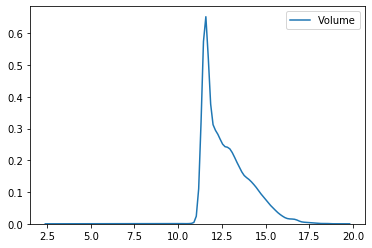

In [354]:
# log(table.selectExpr('cast(Volume as double) AS Volume').toPandas()).hist()
import seaborn
from numpy import log

volume = table.selectExpr('cast(Volume as double) AS Volume').toPandas()

seaborn.kdeplot(log(volume.loc[volume['Volume'] > 0, 'Volume']))

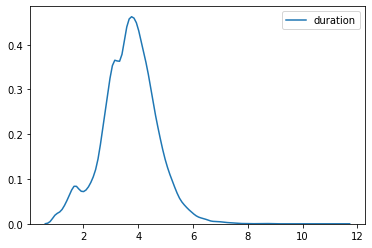

In [370]:
from scipy import stats

# ?stats.boxcox

# duration = table.where('duration > 0').select('duration').toPandas()

# stats.boxcox(duration['duration'])

seaborn.kdeplot(duration['duration']**0.3)

In [334]:
table.groupBy('Status').count().show(truncate=False)

+----------------------+-----+
|Status                |count|
+----------------------+-----+
|Partial Receipt       |486  |
|Fully Received        |2909 |
|No Receipt            |9194 |
|Account Identification|1332 |
|Superceded            |7684 |
+----------------------+-----+



In [337]:
table.groupBy('result').count().show(truncate=False)

+--------------+-----+
|result        |count|
+--------------+-----+
|Call Cancel   |1714 |
|No Answer     |9    |
|Call connected|19880|
|Recorded      |1    |
|Call failed   |1    |
+--------------+-----+



In [335]:
calls.groupBy('call_type').count().show()

+-------------+-----+
|    call_type|count|
+-------------+-----+
|         voip| 6826|
|     tollfree|    3|
|         pstn|36365|
|international|  211|
+-------------+-----+



In [336]:
table.groupBy('call_type').count().show()

+-------------+-----+
|    call_type|count|
+-------------+-----+
|         voip|  143|
|         pstn|21330|
|international|  132|
+-------------+-----+



In [328]:
table.groupBy('Outcome').count().show(truncate=False)

+-------------------------+-----+
|Outcome                  |count|
+-------------------------+-----+
|Needs Account Number     |57   |
|null                     |50   |
|Verbal Zero Balance      |416  |
|Left Voicemail           |12060|
|Remove From Scope        |23   |
|Sent Authorization Letter|6694 |
|Needs Research           |605  |
|Needs Supervisor         |58   |
|Will Not Comply          |148  |
|Need to Receive          |23   |
|Needs Lead               |1    |
|Will Email or Fax        |1470 |
+-------------------------+-----+



In [323]:
table.groupBy('JobTier').count().show(truncate=False)

+-------+-----+
|JobTier|count|
+-------+-----+
|null   |17865|
|1      |1786 |
|3      |56   |
|2      |1898 |
+-------+-----+



In [329]:
table.groupBy('Status').count().show(truncate=False)

+----------------------+-----+
|Status                |count|
+----------------------+-----+
|Partial Receipt       |486  |
|Fully Received        |2909 |
|No Receipt            |9194 |
|Account Identification|1332 |
|Superceded            |7684 |
+----------------------+-----+



In [330]:
table.groupBy('RequestType').count().show(truncate=False)

+-----------+-----+
|RequestType|count|
+-----------+-----+
|Caller     |21476|
|Mass 2     |12   |
|Mass 1     |117  |
+-----------+-----+



In [331]:
table.groupBy('ActivityType').count().show(truncate=False)

+---------------------+-----+
|ActivityType         |count|
+---------------------+-----+
|Called Vendor        |21549|
|Received Call / Email|56   |
+---------------------+-----+



In [261]:
calls.where('call_id = 7002655511387888376').toPandas()

,caller_name,caller_number,callee_name,callee_number,direction,duration,date_time,result,call_id,extension_number,id,name,type,call_type,caller_number_type,callee_number_type,path,has_recording,has_voicemail,date_time_est,CALLED_NUMBER,RECEIVED_NUMBER
0,Xavier Baron,852,Ashton Sower,409,outbound,284,2021-08-31T17:59:50Z,Call connected,7002655511387888376,852,r0Kgyt9FS3eqIo6KhEVIvg,Xavier Baron,user,voip,1,1,extension,False,False,2021-08-31 13:59:50,409,852
1,Xavier Baron,852,Ashton Sower,409,inbound,284,2021-08-31T17:59:50Z,Call connected,7002655511387888376,409,PBO-YsLMTf2ncnsYKSuGvQ,Ashton Sower,user,voip,1,1,extension,False,False,2021-08-31 13:59:50,409,852


In [263]:
# countDuplicates(calls, ['id']).show()

In [285]:
# from pyspark.sql.functions import approxCountDistinct

# date_time is string, date_time_est is timestamp
# ActivityDate appears date_trunc('day', CreatedDate) as GMT time, adjusted to local time

# # 2021-06-15 10:00:00
# table = outbound.where('ObjectID = 35215618')

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

# for column in table.columns:
#     records = table.select(column).dropDuplicates().count()
#     if records > 1:
#         print(column)

# columns = [
#     'duration',
#     'date_time',
#     'call_id',
#     'date_time_est'
# ]

# table.select(columns).toPandas()

# table = outbound.where('call_id = 6985627842959998120')

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

# for column in table.columns:
#     records = table.select(column).dropDuplicates().count()
#     if records > 1:
#         print(column)


# outbound.where('ObjectID = 34393944').selectExpr('ActivityDate', 'cast(ActivityDate as long)').show()

In [112]:
table = outbound.where('trim(upper(ACTIVITYUSER)) != trim(upper(caller_name))')

# table.count()

# countDuplicates(outbound, ['ObjectID']).show()

# name and caller_name same?
outbound.where('ObjectID = 34393944').select('ActivityUser', 'caller_name').show()

+--------------------+------------------+
|        ActivityUser|       caller_name|
+--------------------+------------------+
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|    Charley Taylor|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
+--------------------+------------------+



In [119]:
(
    outbound.where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .select('CreatedDate', 'date_time_est', 'duration')
    .show(truncate=False)
)

+-----------------------+-----------------------+--------+
|CreatedDate            |date_time_est          |duration|
+-----------------------+-----------------------+--------+
|2021-07-23 15:50:34.227|2021-07-23 15:51:04.000|43      |
|2021-07-19 10:37:49.037|2021-07-19 15:47:32.000|209     |
|2021-07-19 10:37:49.037|2021-07-19 10:42:42.000|268     |
|2021-09-13 13:19:05.347|2021-09-13 13:18:32.000|450     |
|2021-07-27 09:28:48.693|2021-07-27 09:29:24.000|16      |
|2021-08-19 20:45:14.59 |2021-08-19 13:53:42.000|240     |
|2021-08-19 21:31:23.363|2021-08-19 13:53:42.000|240     |
|2021-08-26 15:48:52.543|2021-08-26 15:46:52.000|90      |
|2021-09-14 07:58:09.72 |2021-09-14 12:07:44.000|884     |
|2021-09-14 07:58:09.72 |2021-09-14 11:44:29.000|1374    |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:55.000|18      |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:22.000|20      |
|2021-08-26 12:35:42.453|2021-08-26 12:34:16.000|77      |
|2021-09-14 12:20:53.67 |2021-09-14 12:19:17.000|79     

In [143]:
from pyspark.sql.functions import expr

(
    outbound
    .withColumn('date_time_est', expr('cast(date_time_est as timestamp)'))
    .where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .withColumn('seconds', col('CreatedDate').cast('long') - col('date_time_est').cast('long'))
    .select('CreatedDate', 'date_time_est', 'duration', 'seconds')
    .show(truncate=False)
)

+-----------------------+-------------------+--------+-------+
|CreatedDate            |date_time_est      |duration|seconds|
+-----------------------+-------------------+--------+-------+
|2021-07-23 15:50:34.227|2021-07-23 15:51:04|43      |-30    |
|2021-07-19 10:37:49.037|2021-07-19 15:47:32|209     |-18583 |
|2021-07-19 10:37:49.037|2021-07-19 10:42:42|268     |-293   |
|2021-09-13 13:19:05.347|2021-09-13 13:18:32|450     |33     |
|2021-07-27 09:28:48.693|2021-07-27 09:29:24|16      |-36    |
|2021-08-19 20:45:14.59 |2021-08-19 13:53:42|240     |24692  |
|2021-08-19 21:31:23.363|2021-08-19 13:53:42|240     |27461  |
|2021-08-26 15:48:52.543|2021-08-26 15:46:52|90      |120    |
|2021-09-14 07:58:09.72 |2021-09-14 12:07:44|884     |-14975 |
|2021-09-14 07:58:09.72 |2021-09-14 11:44:29|1374    |-13580 |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:55|18      |-88    |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:22|20      |-55    |
|2021-08-26 12:35:42.453|2021-08-26 12:34:16|77      |8

In [153]:
from pyspark.sql.functions import abs

durations = (
    outbound
    .withColumn('date_time_est', expr('cast(date_time_est as timestamp)'))
    .where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .withColumn('seconds', abs(col('CreatedDate').cast('long') - col('date_time_est').cast('long')))
    .withColumn('delta', expr('abs(duration - seconds)'))
    .select('CreatedDate', 'date_time_est', 'duration', 'seconds', 'delta')
    .toPandas()
)

In [157]:
durations.head()

,CreatedDate,date_time_est,duration,seconds,delta
0,2021-07-23 15:50:34.227,2021-07-23 15:51:04,43,30,13
1,2021-07-19 10:37:49.037,2021-07-19 15:47:32,209,18583,18374
2,2021-07-19 10:37:49.037,2021-07-19 10:42:42,268,293,25
3,2021-09-13 13:19:05.347,2021-09-13 13:18:32,450,33,417
4,2021-07-27 09:28:48.693,2021-07-27 09:29:24,16,36,20


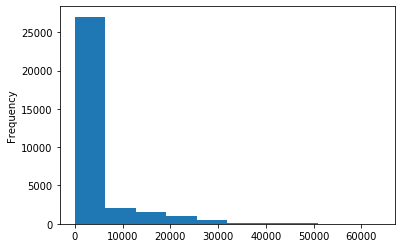

In [156]:
durations['delta'].plot.hist()

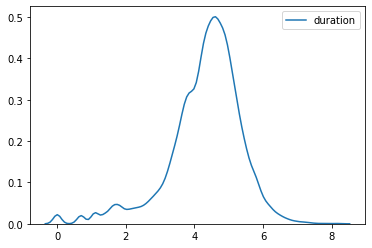

In [188]:
import seaborn
from numpy import log

seaborn.kdeplot(log(durations.loc[durations['duration'] > 0, 'duration']))

In [202]:
log(durations.loc[durations['duration'] > 0, 'duration']).mean()

4.304371591896011

In [193]:
# seaborn.kdeplot(log(durations.loc[durations['delta'] > 0, 'delta']))

# log(durations.loc[durations['delta'] > 0, 'delta']).mean()

# from math import e

# e**5

In [140]:
# outbound.where('date_time_est IS NOT NULL').select(col('date_time_est').cast('long')).show()

outbound.select('date_time_est').dtypes

[('date_time_est', 'string')]

In [80]:
activities.groupBy('ActivityType').count().show(truncate=False)

+-------------------------+-------+
|ActivityType             |count  |
+-------------------------+-------+
|Called Vendor            |98457  |
|Received Call / Email    |4075   |
|null                     |1491895|
|Note Only                |25191  |
+-------------------------+-------+



In [83]:
outbound.groupBy('ActivityType').count().show(truncate=False)

+-------------------------+------+
|ActivityType             |count |
+-------------------------+------+
|Called Vendor            |514089|
|Received Call / Email    |15098 |
|null                     |557135|
|Note Only                |87135 |
+-------------------------+------+



In [88]:
table = outbound.where("trim(ActivityType) = 'Received Call / Email'")

countDuplicates(table, 'ObjectId').show()

+--------+-----+
|ObjectId|count|
+--------+-----+
|35299946|   31|
|35085179|    7|
|32142806|    4|
|34489426|   16|
|32699950|    4|
|37347682|    6|
|36619410|    2|
|36410685|    6|
|33759108|   23|
|33015329|    3|
|36650111|    3|
|33275904|    6|
|37384650|    8|
|37230060|    7|
|33794705|    3|
|32197714|    3|
|33379483|    2|
|33334177|    7|
|33614497|    3|
|35042271|    3|
+--------+-----+
only showing top 20 rows



In [82]:
# outbound.groupBy('ActivityType').count().show(truncate=False)

In [239]:
columns = list(map(lambda x: x.upper(), outbound.columns))

for key, value in {value: columns.count(value) for value in columns}.items():
    if value > 1:
        print(key)

OBJECTID
CREATEDDATE
REFERENCENUMBER
VENDORCONTACTOBJECTID
CUSTOMERNAME


In [71]:
for column in requests.columns:
    print(column)

JobNo
JobTier
CustomerName
CustVendorID
VendorNo
CustVendorGroupID
WNC
StatementWNC
VendorGroupName
Volume
RequestDate
ReferenceNumber
Status
RequestMethod
RequestType
Contact
RequesterFullName
RequestText
LastActivityDate
LastStatementReceivedDate
CreatedDate
CallsheetNo
ObjectID
CallerStatus
ReconStatus
CurrentAssigneeID
CurrentAssigneeName
EnteredReconDate
LastReconQueueName
LastReconQueueEntryDate
AccountsReceived
AccountsRequested
MessageID
VendorContactObjectID


In [ ]:
spark.stop()